In this tutorial we will explore some data which contains right whale calls. It was shared as part of a [2013 Kaggle competition](https://www.kaggle.com/c/whale-detection-challenge). Our goal is not to show the best winning algorithm to detect call, but share a simple pipeline for processing oscillatory data.

Objectives:
* read and extract features form audio data
* apply dimensionality reduction techinques
* unsupervised clustering 
* supervised classification


In [1]:
# importing multiple visualization libraries
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import mlab
import pylab as pl

In [3]:
# importing libraries to manipulate the data files
import os
from glob import glob

In [15]:
import aifc

In [17]:
from scipy.fftpack import rfft

The `train` folder contains many `.aiff` files and a `.csv` document which contains the corresponding labels. 

In [18]:
train_filenames = glob(os.path.join('whale_data','train','*.aiff'))

In [19]:
print('There are '+str(len(train_filenames))+' files.' )

There are 30000 files.


In [20]:
# read the labels
import pandas as pd
labels = pd.read_csv(os.path.join('whale_data','train.csv'), index_col = 0)

In [21]:
# names of files which contain aiff
print(labels[labels['label'] == 1].index)

Index(['train6.aiff', 'train7.aiff', 'train9.aiff', 'train12.aiff',
       'train28.aiff', 'train31.aiff', 'train32.aiff', 'train55.aiff',
       'train64.aiff', 'train73.aiff',
       ...
       'train29967.aiff', 'train29968.aiff', 'train29969.aiff',
       'train29970.aiff', 'train29971.aiff', 'train29972.aiff',
       'train29980.aiff', 'train29981.aiff', 'train29991.aiff',
       'train29992.aiff'],
      dtype='object', name='clip_name', length=7027)


In [22]:
whale_labels = labels[labels['label'] == 1].index

In [23]:
whale_labels[0]

'train6.aiff'

In [24]:
whale_sample_file = whale_labels[600] 
whale_aiff = aifc.open(os.path.join('whale_data','train',whale_sample_file),'r')
print ("Channels:", whale_aiff.getnchannels()) 
print ("Frames:", whale_aiff.getnframes() )
print ("Frame rate (frames per second):", whale_aiff.getframerate())

Channels: 1
Frames: 4000
Frame rate (frames per second): 2000


Working directly with Let's calculate the spectrogram for each of them.

In [25]:
def PlotSpecgram(P, freqs, bins):
    """Spectrogram"""
    Z = np.flipud(P) # flip rows so that top goes to bottom, bottom to top, etc.
    xextent = 0, np.amax(bins)
    xmin, xmax = xextent
    extent = xmin, xmax, freqs[0], freqs[-1]

    im = pl.imshow(Z, extent=extent)
    pl.axis('auto')
    pl.xlim([0.0, bins[-1]])
    pl.ylim([0, 1000])

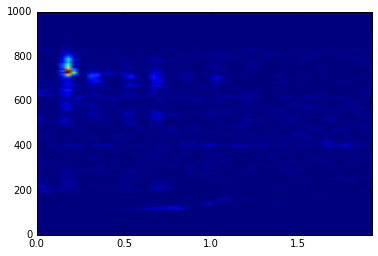

In [26]:
whale_strSig = whale_aiff.readframes(whale_aiff.getnframes())
whale_array = np.fromstring(whale_strSig, np.short).byteswap()
params = {'NFFT':256, 'Fs':2000, 'noverlap':192}
P, freqs, bins = mlab.specgram(whale_array, **params)
PlotSpecgram(P, freqs, bins)

In [27]:
P.shape

(129, 59)

In [28]:
# let's calculate all spectrograms

In [29]:
# create a dictionary which contains all the spectrograms
spec_dict = {}

In [30]:
for filename in train_filenames:
    aiff = aifc.open(filename,'r')
    whale_strSig = aiff.readframes(aiff.getnframes())
    whale_array = np.fromstring(whale_strSig, np.short).byteswap()
    P, freqs, bins = mlab.specgram(whale_array, **params)
    spec_dict[filename] = P[:60,:]
    
    

In [31]:
# they are all same length I think

In [32]:
# let's put them in standard features x samples format

In [40]:
feature_dict = {}

In [41]:
#for key in spec_dict:
#    feature_dict[key] = spec_dict[key].ravel()

In [42]:
# The key below depends on the directory structure
for key in train_filenames:
    feature_dict[key[17:]] = spec_dict[key].ravel()

NameError: name 'spec_dict' is not defined

In [36]:
X = pd.DataFrame(feature_dict)

In [37]:
#del feature_dict
del spec_dict

In [66]:
X.shape

(3540, 30000)

In [67]:
X.columns[0]

'train1.aiff'

In [43]:
X.iloc[:20000,:].T.shape

(30000, 3540)

In [44]:
# perform PCA & ICA

In [45]:
from sklearn.decomposition import PCA
pca = PCA(n_components=30,copy=False)
X_transformed = pca.fit_transform(X.iloc[:,:20000].T)

In [ ]:
X_transformed.shape

In [ ]:
print(pca.explained_variance_ratio_)
plt.plot(pca.singular_values_)

In [ ]:
plt.imshow(X_transformed[:,20].reshape(129,59).T)

In [ ]:
from sklearn.decomposition import FastICA
ica = FastICA(n_components=5)
X_transformed = ica.fit(X).transform(X)

In [ ]:
plt.imshow(X_transformed[:,0].reshape(129,59).T)

In [ ]:
# Unsupervised Learning
# I can try to cluster them and plot them with labels 

In [ ]:
from sklearn.cluster import KMeans

In [72]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(X_transformed)

NameError: name 'KMeans' is not defined

In [ ]:
labels['label'][X.columns]

In [ ]:
kmeans.labels_

In [ ]:
(labels['label'] - (1 - kmeans.labels_))

In [ ]:
kmeans.labels_.shape

In [ ]:
X_transformed.shape

In [ ]:
plt.scatter(X_transformed[:,0],X_transformed[:,1],[],kmeans.labels_)

In [ ]:
X_transformed.shape

In [ ]:
X.max()

### Supervised Prediction

In [ ]:
Y = X.as_matrix().astype(np.float)

In [46]:
from sklearn.ensemble import RandomForestClassifier

In [47]:
X.head()

,train1.aiff,train10.aiff,train100.aiff,train1000.aiff,train10000.aiff,train10001.aiff,train10002.aiff,train10003.aiff,train10004.aiff,train10005.aiff,...,train9990.aiff,train9991.aiff,train9992.aiff,train9993.aiff,train9994.aiff,train9995.aiff,train9996.aiff,train9997.aiff,train9998.aiff,train9999.aiff
0,-3.810013,-3.842712,-3.784397,-3.837424,-3.839975,-3.897497,-3.303040,-3.820926,-3.833590,-3.838876,...,0.045872,0.133007,0.141928,0.106960,0.046729,0.155241,0.187832,0.011585,0.061082,0.097990
1,-4.042564,-4.009494,-4.105573,-4.003871,-4.016084,-3.986620,-4.002104,-4.050279,-3.899766,-4.006726,...,0.132012,0.106819,0.086542,0.114405,0.098374,0.028129,0.001372,0.003876,0.095292,0.113787
2,-7.347830,-7.339269,-7.392951,-7.333550,-7.353221,-7.386494,-7.452062,-7.350787,-7.409601,-7.359816,...,0.086293,0.061886,0.064891,0.148604,0.093653,0.065195,0.079974,0.002283,0.166256,0.140293
3,-5.642751,-5.620791,-5.634692,-5.608343,-5.620007,-5.679055,-5.672845,-5.599222,-5.678070,-5.631417,...,0.060814,0.139928,0.124817,0.165656,0.100718,0.058060,0.190541,0.006882,0.088204,0.093512
4,-3.437128,-3.471923,-3.464543,-3.479506,-3.479659,-3.379245,-3.472660,-2.770801,-3.425605,-3.472556,...,0.185666,0.124454,0.069517,0.063975,0.117573,0.131793,0.107354,0.173088,0.138021,0.154029


In [75]:
clf = RandomForestClassifier(max_depth=10, random_state=0)
clf.fit(X.T.iloc[:15000,:], np.array(labels['label'][X.columns][:15000]))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [76]:
# prediction on the testing dataset
test_accuracy = 1 - np.sum(np.abs(clf.predict(X.T.iloc[15000:,:])-labels['label'][X.columns][15000:]))/15000.
print('Accuracy on the test dataset is '+ str(test_accuracy))

Accuracy on the test dataset is 0.7918


In [77]:
X_transformed.shape

(20000, 30)

In [78]:
np.sum(np.array(labels['label'][:15000]))

3313

How should we evaluate performance? First let's look at the accuracy on the train dataset: it better be good.


In [79]:
# prediction on the training dataset
train_accuracy = 1 - np.sum(np.abs(clf.predict(X.T.iloc[:15000,:]) - labels['label'][X.columns][:15000]))/15000.
print('Accuracy on the train dataset is '+ str(train_accuracy))

Accuracy on the train dataset is 0.958333333333


In [80]:
np.array(labels['label']).sum()

7027

In [82]:
# ROC AUC Curve

In [81]:
from sklearn.metrics import roc_auc_score
print(X.T.iloc[15000:,:].shape)
y_score = clf.predict_proba(X.T.iloc[15000:,:])[:,1]
print(y_score[-20:])
print(y_score.shape)


roc_auc_score(labels['label'][X.columns][15000:], y_score)


(15000, 3540)
[ 0.00129387  0.00129387  0.00129387  0.00129387  0.00129387  0.00129387
  0.00129387  0.00129387  0.00129387  0.00129387  0.00129387  0.00129387
  0.00129387  0.00129387  0.00129387  0.00129387  0.00129387  0.00129387
  0.00129387  0.00129387]
(15000,)


0.59999234967428328

In [83]:
np.sum(np.abs(clf.predict(X.T.iloc[:15000,:])))

3042

Let's use the low dimensional features.

In [60]:
clf = RandomForestClassifier(max_depth=10, random_state=0)
clf.fit(X_transformed[:15000,:], np.array(labels['label'][X.columns][:15000]))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [61]:
X_transformed.shape

(20000, 30)

In [69]:
train_accuracy = 1 - np.sum(np.abs(clf.predict(X_transformed[:15000,:]) - labels['label'][X.columns][:15000]))/15000.
print('Accuracy on the train dataset is '+ str(train_accuracy))

Accuracy on the train dataset is 0.888933333333


In [71]:
test_accuracy = 1 - np.sum(np.abs(clf.predict(X_transformed[15000:,:]) - labels['label'][X.columns][15000:20000]))/5000.
print('Accuracy on the test dataset is '+ str(test_accuracy))

Accuracy on the test dataset is 0.7724


Extra:

randomly generate the subsamples.

true cross validation

Time shifting

Equalize spectrograms


Exercise:
Try a different classifier: gradient boosting, SVM

## Large Data Processing

What if we have many many such files???

* We can speed up the computation of the spectrograms by parallelizing this step by file.
* We will end up with a humongous features x samples array on which to run PCA.
* If we can load this array in RAM, we can apply randomized PCA on it.
* If not we can use dask to perform the PCA (SVD)

In [36]:
# put everything in one function
def process_file(filename):
    aiff = aifc.open(filename,'r')
    whale_strSig = aiff.readframes(aiff.getnframes())
    whale_array = np.fromstring(whale_strSig, np.short).byteswap()
    P, freqs, bins = mlab.specgram(whale_array, **params)
    return(P.ravel())

In [37]:
from dask import delayed

import dask.array as da

In [49]:
process_file_dask = delayed(process_file)
# create delayed evaluations
lazy_values = [process_file_dask(filename) for filename in train_filenames]
# create a list of dask arrays
arrays = [da.from_delayed(lazy_value, shape=(7621,), dtype='float64') for lazy_value in lazy_values]

In [50]:
arrays[0].dtype
stack = da.stack(arrays, axis=0)

In [52]:
# dimensions
stack

dask.array<stack-0..., shape=(30000, 7621), dtype=float64, chunksize=(1, 7621)>

In [54]:
u, s, vt = da.linalg.svd(stack)

In [73]:
# s.compute()

In [39]:
arrays.shape

AttributeError: 'list' object has no attribute 'shape'